In [18]:
import sys
sys.path.append('../')

import os
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

DATA_PATH = "/dust3r/masked_dust3r/data/jackal_dense"

with open(os.path.join(DATA_PATH, "transforms.json"), "r") as f:
    transforms = json.load(f)

[[ 1.71664153e+02 -8.78915781e+00 -8.86699397e+01]
 [ 1.45217269e+02  7.77733886e+00 -9.97969012e+00]
 [ 1.45534230e+02  9.35504123e+00 -7.68203435e+00]
 [ 1.45848518e+02  1.06359740e+01 -5.78446273e+00]
 [ 1.46208780e+02  1.19062230e+01 -3.87248423e+00]
 [ 1.46619243e+02  1.31741913e+01 -1.92833747e+00]
 [ 1.47072833e+02  1.44336423e+01  3.82530668e-02]
 [ 1.47745362e+02  1.60314560e+01  2.61378854e+00]
 [ 1.48502564e+02  1.76133002e+01  5.24938991e+00]
 [ 1.49378632e+02  1.92316167e+01  8.05224168e+00]]


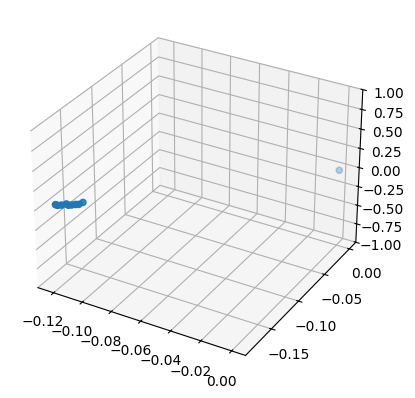

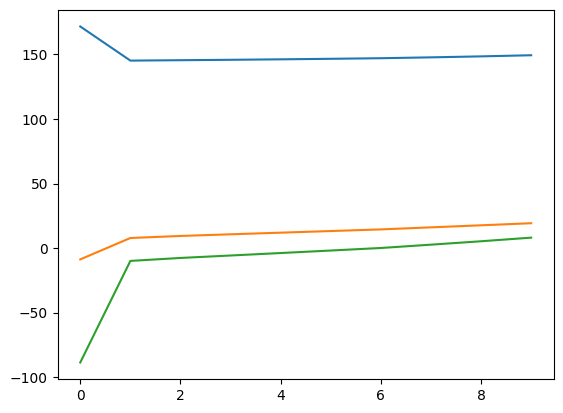

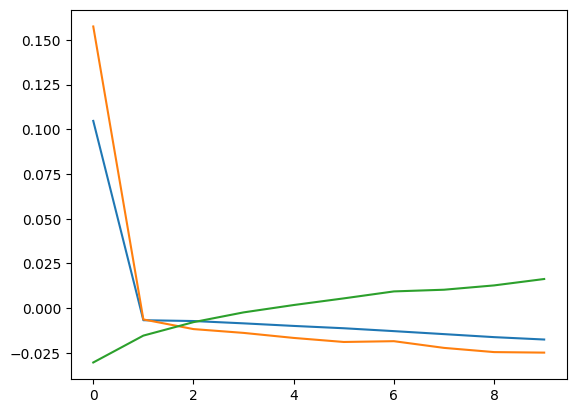

In [19]:
transforms["frames"] = transforms["frames"][:10]

#transforms["frames"] = rotate_best_fit_plane(transforms["frames"])

OPENGL = np.array([
    [1, 0, 0, 0],
    [0, -1, 0, 0],
    [0, 0, -1, 0],
    [0, 0, 0, 1]
])

points = []
euler_angle = []
for frame in transforms["frames"]:
    tf = np.array(frame["transform_matrix"])
    tf = np.dot(tf, OPENGL)
    points.append(tf[0:3, 3])
    r = R.from_matrix(tf[0:3, 0:3])
    euler_angle.append(r.as_euler('xyz', degrees=True))
    
points = np.array(points)
euler_angle = np.array(euler_angle)
print(euler_angle)

# Plot the points

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
#Set z-axis
ax.set_zlim(-1, 1)

# Plot the euler angles with respect to index
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(euler_angle[:, 0], label="x")
ax.plot(euler_angle[:, 1], label="y")
ax.plot(euler_angle[:, 2], label="z")

# Plot the points with respect to index
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(points[:, 0] - points[:,0].sum()/len(points[:,0]), label="x")
ax.plot(points[:, 1] - points[:,1].sum()/len(points[:,1]), label="y")
ax.plot(points[:, 2] - points[:,2].sum()/len(points[:,2]), label="z")

plt.show()

[[ 4.49771869e+01  0.00000000e+00  0.00000000e+00]
 [ 4.49771869e+01  0.00000000e+00  3.00000000e+00]
 [ 4.49771869e+01  0.00000000e+00  6.00000000e+00]
 [ 4.49771869e+01  0.00000000e+00  9.00000000e+00]
 [ 4.49771869e+01  1.27222187e-14  1.20000000e+01]
 [ 4.49771869e+01  0.00000000e+00  1.50000000e+01]
 [ 4.49771869e+01  0.00000000e+00  1.80000000e+01]
 [ 4.49771869e+01  0.00000000e+00  2.10000000e+01]
 [ 4.49771869e+01  0.00000000e+00  2.40000000e+01]
 [ 4.49771869e+01  1.27222187e-14  2.70000000e+01]
 [ 4.49771869e+01  0.00000000e+00  3.00000000e+01]
 [ 4.49771869e+01  0.00000000e+00  3.30000000e+01]
 [ 4.49771869e+01  0.00000000e+00  3.60000000e+01]
 [ 4.49771869e+01  1.27222187e-14  3.90000000e+01]
 [ 4.49771869e+01  0.00000000e+00  4.20000000e+01]
 [ 4.49771869e+01 -1.27222187e-14  4.50000000e+01]
 [ 4.49771869e+01  0.00000000e+00  4.80000000e+01]
 [ 4.49771869e+01  0.00000000e+00  5.10000000e+01]
 [ 4.49771869e+01  0.00000000e+00  5.40000000e+01]
 [ 4.49771869e+01  0.00000000e+

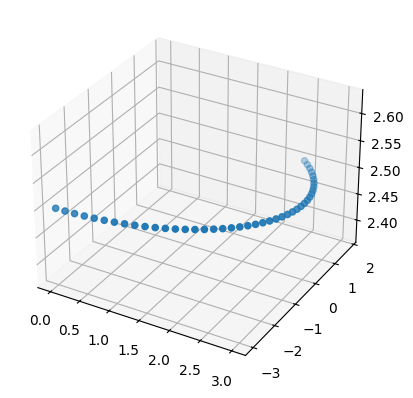

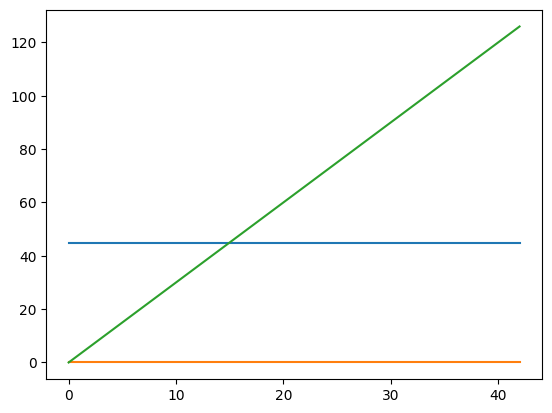

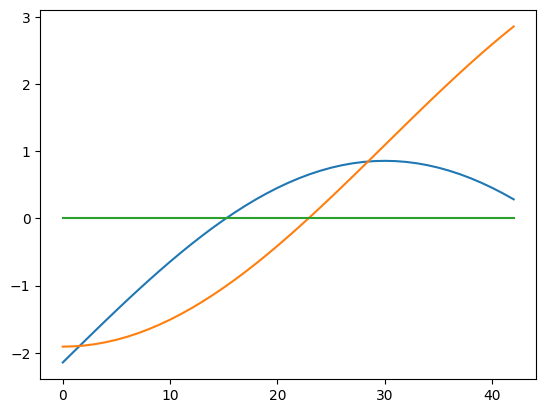

In [12]:
with open(os.path.join(DATA_PATH, "ground_truth.json"), "r") as f:
    ground_truth = json.load(f)
    
#transforms["frames"] = rotate_best_fit_plane(transforms["frames"])

ground_truth["frames"] = ground_truth["frames"][0:len(transforms["frames"])]

points = []
euler_angle = []
for frame in ground_truth["frames"]:
    tf = frame["transform_matrix"]
    tf = np.array(tf).reshape(4, 4)
    points.append(tf[0:3, 3])
    r = R.from_matrix(tf[0:3, 0:3])
    euler_angle.append(r.as_euler('xyz', degrees=True))

points = np.array(points)
euler_angle = np.array(euler_angle)
print(euler_angle)

# Plot the points

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2])

# Plot the euler angles with respect to index
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(euler_angle[:, 0], label="x")
ax.plot(euler_angle[:, 1], label="y")
ax.plot(euler_angle[:, 2], label="z")

# Plot the points with respect to index
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(points[:, 0] - points[:,0].sum()/len(points[:,0]), label="x")
ax.plot(points[:, 1] - points[:,1].sum()/len(points[:,1]), label="y")
ax.plot(points[:, 2] - points[:,2].sum()/len(points[:,2]), label="z")

plt.show()